In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, UnivariateSpline, Rbf, make_interp_spline
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import ffn
%matplotlib inline

In [2]:
find_mask = lambda array : np.nonzero(array)[0]
DIS = lambda ground, inter : np.around(np.sum(np.abs(ground-inter)), decimals = 2)

def INTER(sdm, mask, func = interp1d):
    y_axis = np.delete(sdm, mask)
    interp_func = func(find_mask(~mask), y_axis)
    mask_val = interp_func(find_mask(mask))
    sdm[find_mask(mask)] = mask_val
    return np.around(sdm, decimals=2)

def LR(sdm, mask):
    y_axis = np.delete(sdm, mask)
    model = LinearRegression()
    model.fit(find_mask(~mask).reshape(-1, 1), y_axis)
    mask_val = model.predict(find_mask(mask).reshape(-1, 1))
    sdm[find_mask(mask)] = mask_val
    return np.around(sdm, decimals=2)

inter_func = {"interp1d": interp1d,
              "UnivariateSpline" : UnivariateSpline, 
              "Rbf" : Rbf, 
              "make_interp_spline" : make_interp_spline,
              "LinearRegression": None}


In [3]:
def get_res(day = 500, mask_percent = 0.2, inter_name=None, func = None):
    SD = pd.read_csv("../data/stock.csv", skiprows=[1],index_col=0)
    SD = SD[-day:]
    title = SD.columns
    SD = SD.to_numpy()
    SDM = SD.copy()

    MASK = np.random.choice([True, False], size=SDM.shape, p=[mask_percent, 1-mask_percent])
    MASK[0, :] = MASK[-1, :] = False
    SDM = np.ma.masked_array(SDM, mask=MASK)


    loss_queue = dict()
    for col, col_name in enumerate(title):
        if inter_name == "LinearRegression":
            inter_res = LR(SDM[:, col].copy(), MASK[:, col].copy())
        else:
            inter_res = INTER(SDM[:, col].copy(), MASK[:, col].copy(), func)
        inter_dis = DIS(SD[:, col], inter_res)
        return inter_dis/(day*mask_percent*np.mean(SD[:, col])/100)


In [4]:
output = dict()
def AVG(lst):
    return sum(lst)/len(lst)
for k1 in inter_func.keys():
    output[k1] = dict()
for day in tqdm(range(20, 100, 10)):

    avg = dict()
    for name in inter_func.keys():
        avg[name] = list()
    for _ in range(10):
        for k1, val1 in inter_func.items():
            ret = get_res(day=day,inter_name=k1, func=val1)
            avg[k1].append(ret)
    
    for name in inter_func.keys():
        output[name][day] = AVG(avg[name])
print(output)

100%|██████████| 8/8 [00:00<00:00, 12.93it/s]

{'interp1d': {20: 2.5012005243371154, 30: 1.766381175969045, 40: 2.09561011405381, 50: 2.1283348467159597, 60: 3.253964154744073, 70: 1.9091896599191127, 80: 1.9076664018815925, 90: 2.197630793035463}, 'UnivariateSpline': {20: 2.3175527473620905, 30: 1.95526095310275, 40: 2.9834534723993364, 50: 3.2568858909499716, 60: 2.4325859871544493, 70: 1.967534330049982, 80: 2.5624268037593003, 90: 2.3078970792536326}, 'Rbf': {20: 1.2699600690463726, 30: 1.708503438618513, 40: 2.8872527305350113, 50: 3.0671509491071047, 60: 2.886340190714965, 70: 2.742257092073995, 80: 1.9595713977738634, 90: 2.5414070493889804}, 'make_interp_spline': {20: 1.285318128133801, 30: 2.1579070462814665, 40: 2.094938946087315, 50: 2.7511566567215815, 60: 2.7792008733075826, 70: 2.396854341062323, 80: 2.284014038140704, 90: 2.2369373341430343}, 'LinearRegression': {20: 3.003041328320693, 30: 3.7115764356195284, 40: 5.3391411734700736, 50: 8.405154148830373, 60: 8.931021822917902, 70: 7.3980235383018655, 80: 5.363111619

In [5]:
df = pd.DataFrame(output)
# df = df.drop(columns=['LinearRegression'])
print(df)

    interp1d  UnivariateSpline       Rbf  make_interp_spline  LinearRegression
20  2.501201          2.317553  1.269960            1.285318          3.003041
30  1.766381          1.955261  1.708503            2.157907          3.711576
40  2.095610          2.983453  2.887253            2.094939          5.339141
50  2.128335          3.256886  3.067151            2.751157          8.405154
60  3.253964          2.432586  2.886340            2.779201          8.931022
70  1.909190          1.967534  2.742257            2.396854          7.398024
80  1.907666          2.562427  1.959571            2.284014          5.363112
90  2.197631          2.307897  2.541407            2.236937          6.814590


In [6]:
print(inter_func.keys())

dict_keys(['interp1d', 'UnivariateSpline', 'Rbf', 'make_interp_spline', 'LinearRegression'])


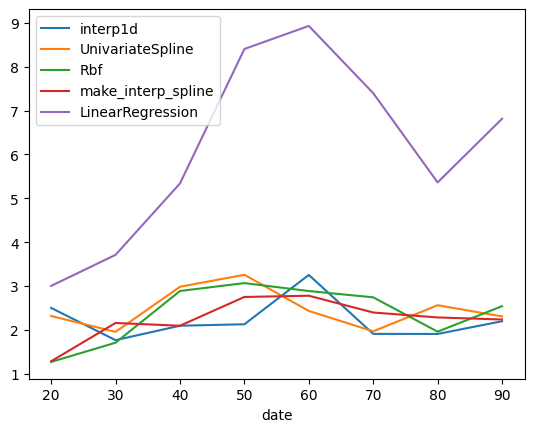

In [7]:
df.index.name = 'date'
df.to_csv("./mask.csv")
sns.lineplot(data=df[-200:],dashes=False)
# sns.lineplot(data=Risk_Table[-200:],dashes=False)
plt.show()

In [9]:
prices = pd.read_csv("../data/stock.csv", index_col=0)
# length = [100, 200, 500, 1000, 2000]
Risk_Table = pd.DataFrame(columns=prices.columns)
import ffn
for l in tqdm(range(10, 1000, 5)):
    test = prices.iloc[-l:]
    Dnext = test[ 1:].reset_index(drop=True)
    Dthis = test[:-1].reset_index(drop=True)
    Risk_each_day = (Dnext - Dthis)**2
    Risk_square = Risk_each_day.sum(axis=0)/test.shape[0]
    Risk = Risk_square**(1/2)
    Risk.name = f"{l}"
    Risk_Table = pd.concat([Risk_Table, Risk.to_frame().T])
print(Risk_Table)

100%|██████████| 198/198 [00:00<00:00, 1224.36it/s]

         meta      goog      amzn       nflx      aapl
10   3.849566  1.918518  1.757255   9.847244  2.841072
15   3.993372  2.232134  2.047562  10.884091  3.041927
20   3.568919  2.078439  1.842994   9.659142  2.991261
25   3.362821  1.948613  1.815428   9.497568  2.754481
30   3.883401  2.261740  2.738556  10.005453  3.482111
..        ...       ...       ...        ...       ...
975  7.135606  2.310295  3.309246  12.770237  2.845748
980  7.135606  2.310295  3.309246  12.770237  2.845748
985  7.135606  2.310295  3.309246  12.770237  2.845748
990  7.135606  2.310295  3.309246  12.770237  2.845748
995  7.135606  2.310295  3.309246  12.770237  2.845748

[198 rows x 5 columns]


         meta      goog      amzn       nflx      aapl
10        NaN       NaN       NaN        NaN       NaN
15        NaN       NaN       NaN        NaN       NaN
20        NaN       NaN       NaN        NaN       NaN
25        NaN       NaN       NaN        NaN       NaN
30   3.731616  2.087889  2.040359   9.978700  3.022171
..        ...       ...       ...        ...       ...
975  7.135606  2.310295  3.309246  12.770237  2.845748
980  7.135606  2.310295  3.309246  12.770237  2.845748
985  7.135606  2.310295  3.309246  12.770237  2.845748
990  7.135606  2.310295  3.309246  12.770237  2.845748
995  7.135606  2.310295  3.309246  12.770237  2.845748

[198 rows x 5 columns]


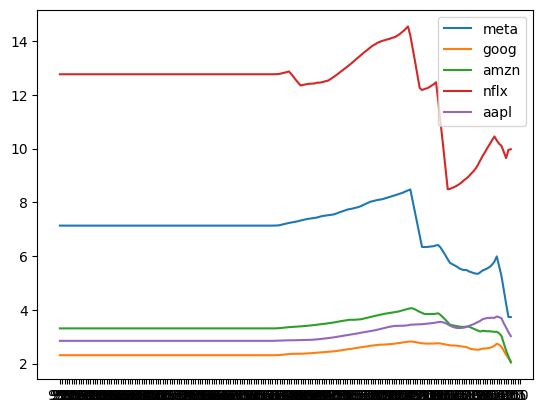

In [10]:
# Risk_Table.index.name = 'date'
Risk_Table = Risk_Table.rolling(5).mean()
print(Risk_Table)
sns.lineplot(data=Risk_Table,dashes=False)
plt.gca().invert_xaxis()

In [ ]:

Risk_Table.to_csv("./risk.csv")

In [ ]:
print(output)

In [ ]:
# SDM stock_data_masked
mask_percent = 0.3
title = SD.columns
SD = SD.to_numpy()
SDM = SD.copy()

MASK = np.random.choice([True, False], size=SDM.shape, p=[mask_percent, 1-mask_percent])
MASK[0, :] = MASK[-1, :] = False
SDM = np.ma.masked_array(SDM, mask=MASK)

model = LinearRegression()
inter_func = {"interp1d": interp1d,
              "UnivariateSpline" : UnivariateSpline, 
              "Rbf" : Rbf, 
              "make_interp_spline" : make_interp_spline,
              "LinearRegression": model}
stock_avg = np.mean(SD, axis=0)